Confirm that the simulated spectra generated using dark/bright sky are sensible

In [50]:
import os
import numpy as np 
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM
# -- desihub -- 
import redrock as RedRock
from redrock.external import desi
from redrock import templates as rr_templates

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Read in GAMA-legacy catalog in `field` region for the meta data

In [41]:
field = 'g15'
# read in GAMA-Legacy survey
cata = Cat.GamaLegacy()
gleg = cata.Read(field)
if field == 'g09': 
    nblocks = 26
elif field == 'g15': 
    nblocks = 64

In [42]:
redshift = gleg['gama-spec']['z']
ngal = len(redshift)
print('%i galaxies total' % ngal)

63004 galaxies total


In [43]:
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude from Legacy photometry aperture flux
g_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_g'][:,1])
r_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# apparent magnitude from GAMA photometry
g_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_g'])
r_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_r'])
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]

Read in dark sky simulated spectra for galaxy `i_gal`

In [44]:
i_block = 5
dir_redrock = ''.join([UT.dat_dir(), 'redrock/'])
dir_spectra = ''.join([UT.dat_dir(), 'spectra/'])

f_z_dark = ''.join([dir_redrock, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([dir_spectra, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_dark = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')

f_z_bright = ''.join([dir_redrock, 
                      'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zbright_data = fits.open(f_z_bright)[1].data

f_i_bright = ''.join([dir_spectra, 
                      'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_bright = np.loadtxt(f_i_bright, unpack=True, usecols=[0], dtype='i')

In [45]:
assert np.array_equal(i_dark, i_bright)
print('%i simulated spectra with redrock redshifts' % len(zdark_data['Z']))

1000 simulated spectra with redrock redshifts


Read in simulated spectra

In [52]:
f_spec_dark = ''.join([dir_spectra, 
                       'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.fits'])

f_spec_bright = ''.join([dir_spectra, 
                         'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.fits'])
target_bright = desi.DistTargetsDESI(f_spec_bright)._my_data
target_dark = desi.DistTargetsDESI(f_spec_dark)._my_data

Read in accompanying redrock output data

In [53]:
f_rr_dark = ''.join([dir_redrock, 
                     'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.h5'])
f_rr_bright = ''.join([UT.dat_dir(), 'redrock/', 
                     'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.h5'])
zscan_dark, zfit_dark = RedRock.results.read_zscan(f_rr_dark)
zscan_bright, zfit_bright = RedRock.results.read_zscan(f_rr_bright)

In [79]:
def GAMA_subsample(index, colour='C0'): 
    fig = plt.figure(figsize=(15, 4))
    ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, y, ylbl in zip(range(1,4), ys, ylbls):
        sub = fig.add_subplot(1,3,i)
        sub.scatter(r_absmag_gama, y, c='k', s=1.)
        sub.scatter(r_absmag_gama[index], y[index], c=colour, s=1.)
        if i == 2: sub.set_xlabel('$M_{0.1r}$ from GAMA photo.', fontsize=20)
        sub.set_xlim([-14., -24])
        sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
        sub.set_ylim([-0.2, 1.6])
    fig.subplots_adjust(wspace=0.3)

    fig = plt.figure(figsize=(15, 4))
    xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
        sub = fig.add_subplot(1, len(xs), i)
        hasha = (gama_ha > 0)
        sub.scatter(x[hasha], gama_ha[hasha], s=1, c='k')
        sub.scatter(x[np.invert(hasha)], np.repeat(1e-2, np.sum(np.invert(hasha))), s=1, c='k')
        hasha = (gama_ha[index] > 0)
        sub.scatter(x[index][hasha], gama_ha[index][hasha], c=colour, s=1.)
        sub.scatter(x[index][~hasha], np.repeat(1e-2, np.sum(~hasha)), c=colour, s=1.)
        sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
        sub.set_xlim([-0.2, 2.])
        if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
        sub.set_ylim([5e-3, 2e4])
        sub.set_yscale('log')
    fig.subplots_adjust(wspace=0.3)
    return None 

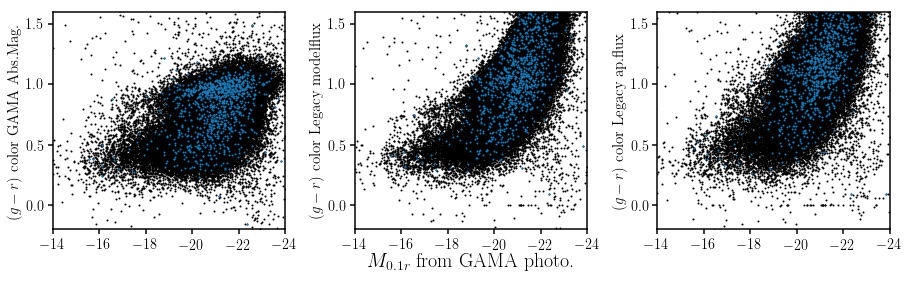

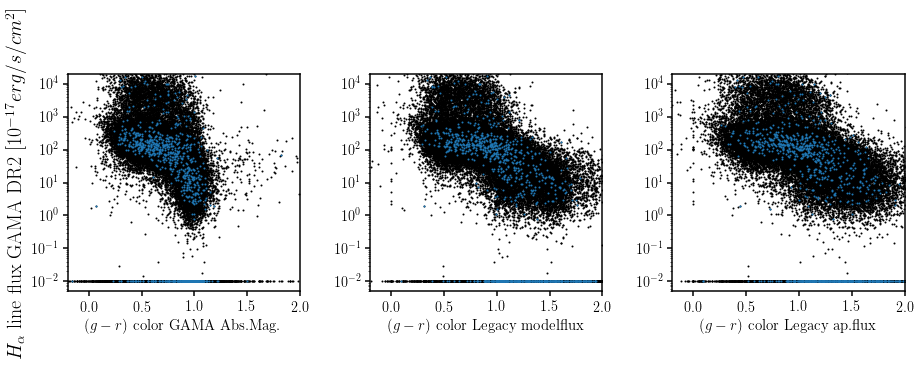

In [80]:
GAMA_subsample(i_dark, colour='C0')

Lets randomly pick a galaxy and take a look at its spectra
```python
igal = 472
```

In [81]:
igal = 472

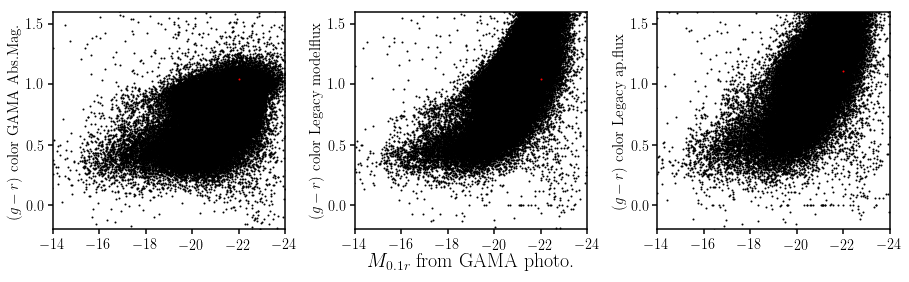

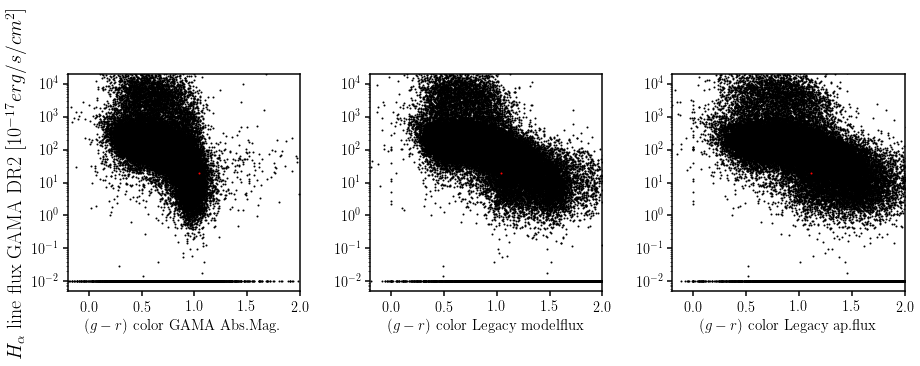

In [142]:
GAMA_subsample(np.array([472]), colour='r')

(-5.0, 10)

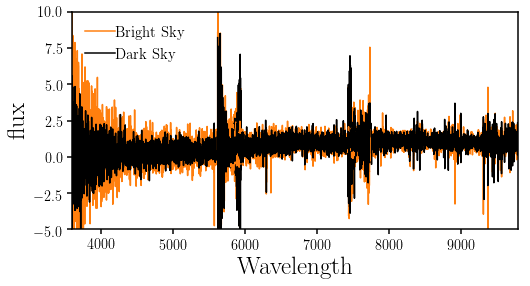

In [83]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
for i_b, s_dark, s_bright in zip(range(len(target_dark[igal].spectra)), target_dark[igal].spectra, target_bright[igal].spectra):
    sub.plot(s_bright.wave, s_bright.flux, c='C1', label='Bright Sky')
    sub.plot(s_dark.wave, s_dark.flux, c='k', label='Dark Sky')    
    if i_b == 0: sub.legend(loc='upper left', markerscale=10, handletextpad=0., prop={'size': 15})
sub.set_xlabel('Wavelength', fontsize=25)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim([-5., 10])

Now lets run the following sanity checks for the galaxy spectras: 
- spectra get fainter with lower $r_\mathrm{apflux}$ magnitude
- spectra get redder with $g-r$ color
- spectra successfully reproduce h$\alpha$ measurements

In [87]:
mr_gr_block = (
    ((g_absmag_gama-r_absmag_gama)[i_dark] > 1.) & ((g_absmag_gama-r_absmag_gama)[i_dark] < 1.1) & 
    (r_absmag_gama[i_dark] > -21.2) & (r_absmag_gama[i_dark] < -20.8))
print('%i galaxies in block' % np.sum(mr_gr_block))

15 galaxies in block


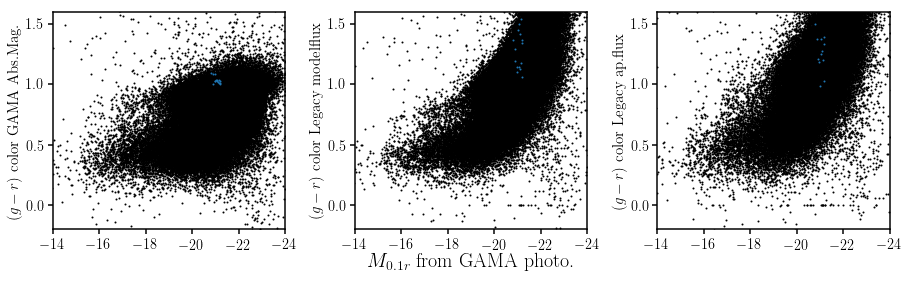

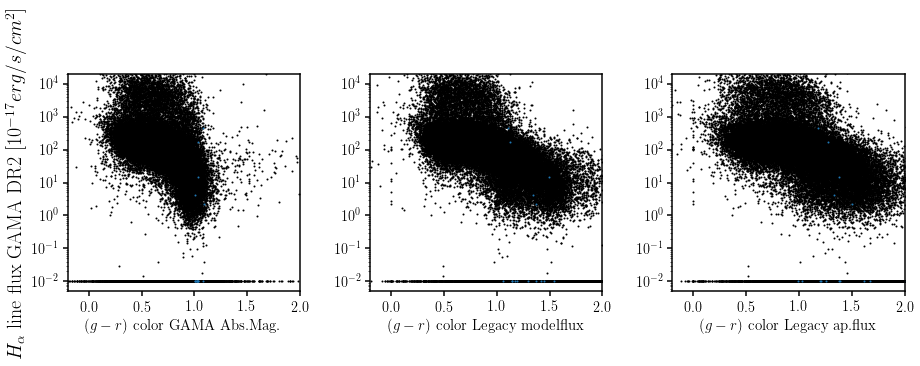

In [88]:
GAMA_subsample(i_dark[mr_gr_block], colour='C0')

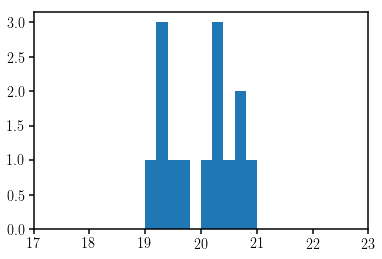

In [94]:
_ = plt.hist(r_mag_legacy_apflux[i_dark[mr_gr_block]], range=(19,21), bins=10)

In [109]:
isort_rmag = np.argsort(r_mag_legacy_apflux[i_dark[mr_gr_block]])

(-5.0, 10)

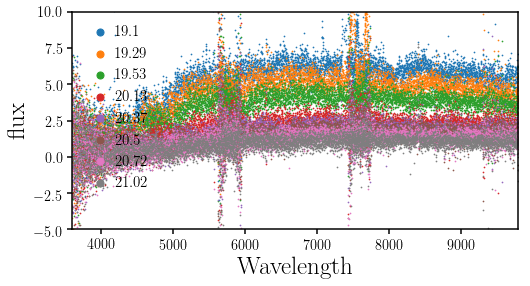

In [119]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
for ii, i_targ in enumerate(np.arange(len(i_dark))[mr_gr_block][isort_rmag][::2]):
    for i_s, s_dark in enumerate(target_dark[i_targ].spectra):
        if i_s == 0: lbl = str(round(r_mag_legacy_apflux[i_dark[i_targ]],2))
        else: lbl = None
        sub.scatter(s_dark.wave, s_dark.flux, c='C'+str(ii), s=0.5, 
                    label=lbl)
sub.legend(loc='upper left', markerscale=10, handletextpad=0., prop={'size': 15})
sub.set_xlabel('Wavelength', fontsize=25)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim([-5., 10])

In [121]:
mr_gr_red_block = (
    ((g_absmag_gama-r_absmag_gama)[i_dark] > 0.4) & ((g_absmag_gama-r_absmag_gama)[i_dark] < 0.6) & 
    (r_absmag_gama[i_dark] > -20.2) & (r_absmag_gama[i_dark] < -19.8))
print('%i galaxies in block' % np.sum(mr_gr_red_block))

18 galaxies in block


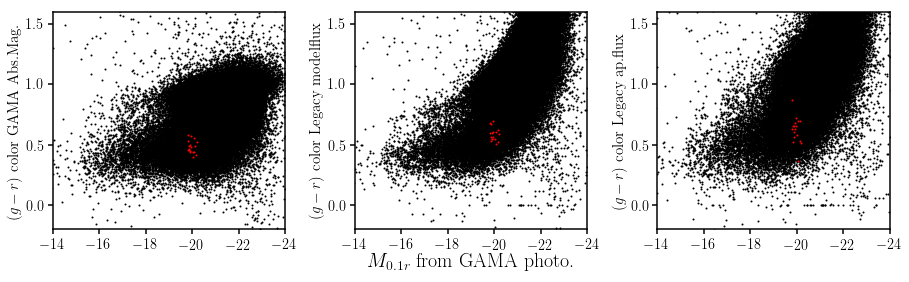

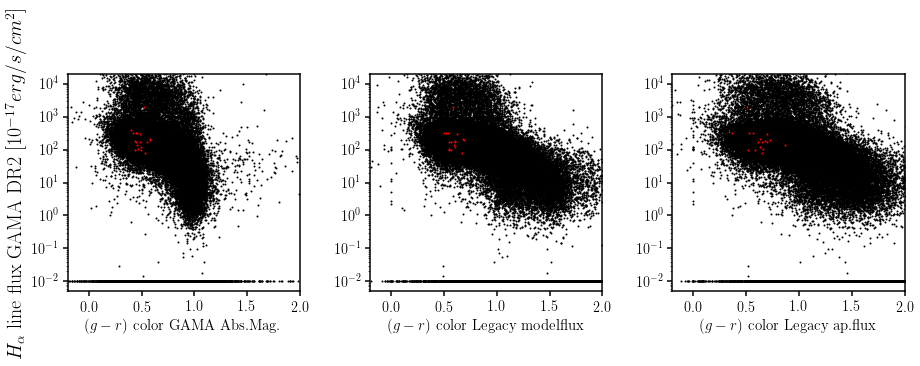

In [123]:
GAMA_subsample(i_dark[mr_gr_red_block], colour='r')

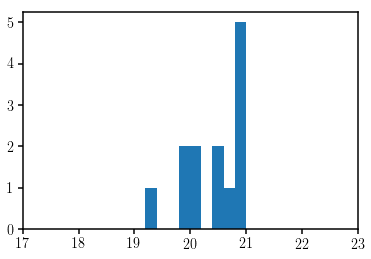

In [124]:
_ = plt.hist(r_mag_legacy_apflux[i_dark[mr_rap_block]], range=(19,21), bins=10)

In [125]:
isort_rmag = np.argsort(r_mag_legacy_apflux[i_dark[mr_gr_red_block]])

(-5.0, 10)

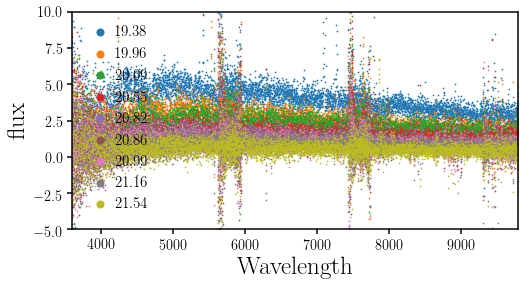

In [126]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
for ii, i_targ in enumerate(np.arange(len(i_dark))[mr_gr_red_block][isort_rmag][::2]):
    for i_s, s_dark in enumerate(target_dark[i_targ].spectra):
        if i_s == 0: lbl = str(round(r_mag_legacy_apflux[i_dark[i_targ]],2))
        else: lbl = None
        sub.scatter(s_dark.wave, s_dark.flux, c='C'+str(ii), s=0.5, 
                    label=lbl)
sub.legend(loc='upper left', markerscale=10, handletextpad=0., prop={'size': 15})
sub.set_xlabel('Wavelength', fontsize=25)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim([-5., 10])

In [127]:
mr_rap_block = (
    (r_mag_legacy_apflux[i_dark] > 20.4) & (r_mag_legacy_apflux[i_dark] < 20.6) & 
    (r_absmag_gama[i_dark] > -21.2) & (r_absmag_gama[i_dark] < -20.8))
print('%i galaxies' % np.sum(mr_rap_block))

18 galaxies


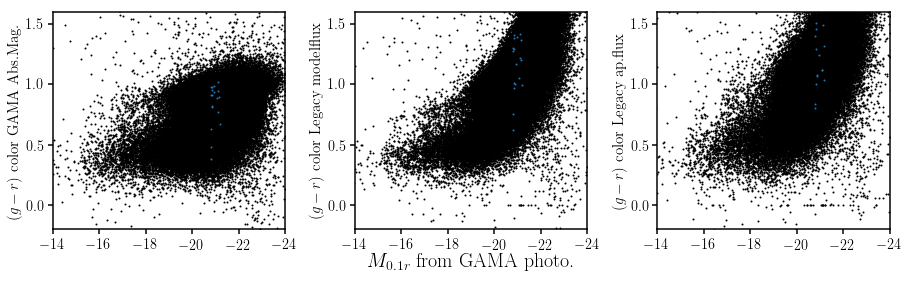

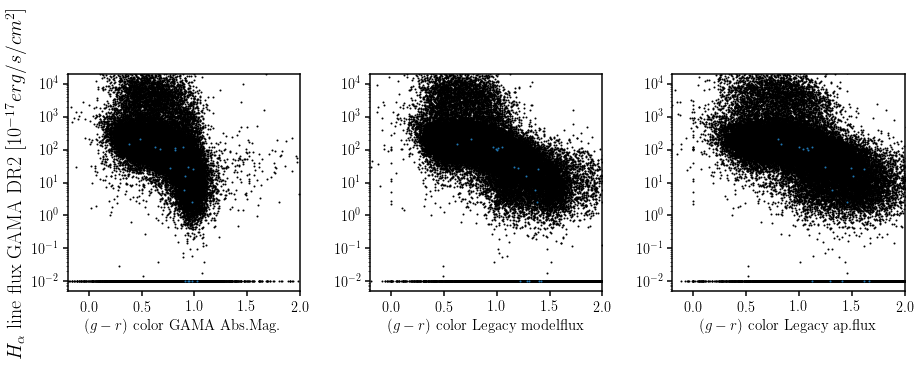

In [129]:
GAMA_subsample(i_dark[mr_rap_block], colour='C0')

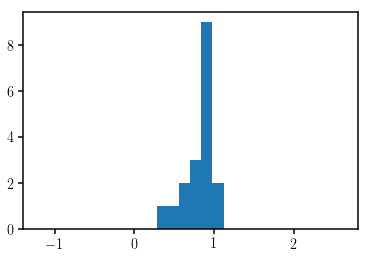

In [133]:
_ = plt.hist((g_absmag_gama-r_absmag_gama)[i_dark[mr_rap_block]], range=(0,1.4), bins=10)


(-5.0, 10)

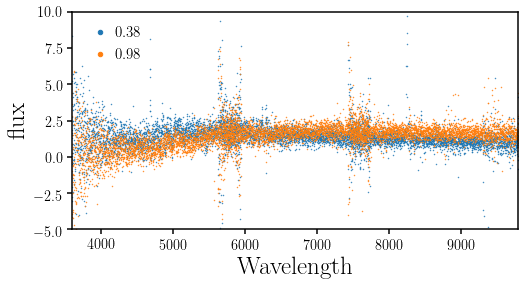

In [141]:
isort_gr = np.argsort((g_absmag_gama-r_absmag_gama)[i_dark[mr_rap_block]])
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
for ii, i_targ in enumerate(np.arange(len(i_dark))[mr_rap_block][isort_gr][::15]):
    for i_s, s_dark in enumerate(target_dark[i_targ].spectra):
        if i_s == 0: lbl = str(round((g_absmag_gama-r_absmag_gama)[i_dark[i_targ]],2))
        else: lbl = None
        sub.scatter(s_dark.wave, s_dark.flux, c='C'+str(ii), s=0.2, 
                    label=lbl)
sub.legend(loc='upper left', markerscale=10, handletextpad=0., prop={'size': 15})
sub.set_xlabel('Wavelength', fontsize=25)
sub.set_xlim([3600., 9800.])
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim([-5., 10])

In [182]:
mr_gr_rmag_block = (
    ((g_absmag_gama-r_absmag_gama)[i_dark] > 1.) & ((g_absmag_gama-r_absmag_gama)[i_dark] < 1.4) & 
    (r_absmag_gama[i_dark] > -21.8) & (r_absmag_gama[i_dark] < -20.6) &
    (r_mag_legacy_apflux[i_dark] > 20.0) & (r_mag_legacy_apflux[i_dark] < 20.8) & 
    (gama_ha[i_dark] > 0.))
print('%i galaxies in block' % np.sum(mr_gr_rmag_block))

9 galaxies in block


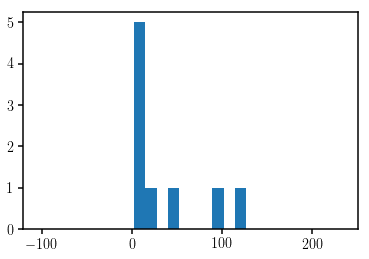

In [183]:
_ = plt.hist(gama_ha[i_dark[mr_gr_rmag_block]], bins=10)

In [184]:
isort_ha = np.argsort(gama_ha[i_dark[mr_gr_rmag_block]])

(0.0, 10)

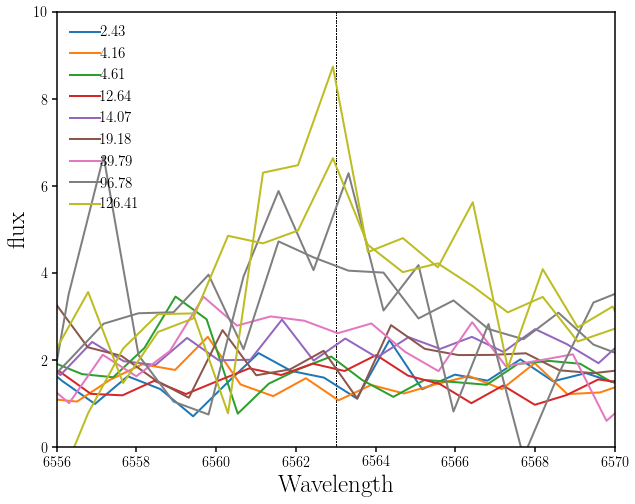

In [195]:
from scipy.signal import medfilt

fig = plt.figure(figsize=(10.,8.))
sub = fig.add_subplot(111)
for ii, i_targ in enumerate(np.arange(len(i_dark))[mr_gr_rmag_block][isort_ha]):
    for i_s, s_dark in enumerate(target_dark[i_targ].spectra):
        if i_s == 0: lbl = str(round(gama_ha[i_dark[i_targ]],2))
        else: lbl = None
        sub.plot(s_dark.wave/(1.+redshift[i_dark[i_targ]]), medfilt(s_dark.flux,1), c='C'+str(ii), lw=2,#s=0.5, 
                    label=lbl)
    sub.vlines(6563., -10., 50., linewidth=1, linestyle=':', color='k')
sub.legend(loc='upper left', markerscale=10, handletextpad=0., prop={'size': 15})
sub.set_xlabel('Wavelength', fontsize=25)
sub.set_xlim([6556., 6570.])
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim([0., 10])